<a href="https://colab.research.google.com/github/abcjamesjordan/fastAI/blob/main/BitcoinRansomware.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Colab and fastai
Code that is required to setup colab for this project.

In [8]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [9]:
from fastbook import *
from fastai.tabular.all import *

# Importing the Data
Here we import the data into a df for fast.ai to use.

In [10]:
import pandas as pd
import numpy as np
import datetime

path = '/content/gdrive/MyDrive/Professional/Data Science/Data/BitcoinRansomware'

df = pd.read_csv('/content/gdrive/MyDrive/Professional/Data Science/Data/BitcoinRansomware/BitcoinHeistData.csv')

In [11]:
df.shape

(2916697, 10)

In [12]:
df.head()

,address,year,day,length,weight,count,looped,neighbors,income,label
0,111K8kZAEnJg245r2cM6y9zgJGHZtJPy6,2017,11,18,0.008333,1,0,2,100050000.0,princetonCerber
1,1123pJv8jzeFQaCV4w644pzQJzVWay2zcA,2016,132,44,0.000244,1,0,1,100000000.0,princetonLocky
2,112536im7hy6wtKbpH1qYDWtTyMRAcA2p7,2016,246,0,1.000000,1,0,2,200000000.0,princetonCerber
3,1126eDRw2wqSkWosjTCre8cjjQW8sSeWH7,2016,322,72,0.003906,1,0,2,71200000.0,princetonCerber
4,1129TSjKtx65E35GiUo4AYVeyo48twbrGX,2016,238,144,0.072848,456,0,1,200000000.0,princetonLocky


In [13]:
# Custom function to convert supplied dates to a proper pandas datetime format
def compose_date(years, months=1, days=1, weeks=None, hours=None, minutes=None,
                 seconds=None, milliseconds=None, microseconds=None, nanoseconds=None):
    years = np.asarray(years) - 1970
    months = np.asarray(months) - 1
    days = np.asarray(days) - 1
    types = ('<M8[Y]', '<m8[M]', '<m8[D]', '<m8[W]', '<m8[h]',
             '<m8[m]', '<m8[s]', '<m8[ms]', '<m8[us]', '<m8[ns]')
    vals = (years, months, days, weeks, hours, minutes, seconds,
            milliseconds, microseconds, nanoseconds)
    return sum(np.asarray(v, dtype=t) for t, v in zip(types, vals)
               if v is not None)

df['date'] = 0
df['date'] = compose_date(df['year'], days=df['day'])

In [14]:
# Change the label column to just legitimate and ransomware to keep the labels simple
df['label_fix'] = 0
df.loc[df['label'] == 'white', 'label_fix'] = 'legitimate'
df.loc[df['label'] != 'white', 'label_fix'] = 'ransomware'
df['label'] = df['label_fix']
df = df.drop(columns=['label_fix'])

In [15]:
# Add which business quarter the datetime is in as a feature
df['quarter'] = df['date'].dt.quarter

# Drop duplicate columns and use fastai date feature tool to extract more info from the datetime column
# https://docs.fast.ai/tabular.core.html#add_datepart
df = df.drop(columns=['year', 'day'])
df = add_datepart(df, 'date')
# need to change 'Week' column from UInt32 to int64
df['Week'] = df['Week'].astype(np.int64)

In [16]:
# Seperate the dataframe so it can be properly reduced in size, while keeping all of the known ransomware examples
df_original = df.copy()
df_original_non_white = df_original.loc[df_original['label'] == 'ransomware']
df_original_white = df_original.loc[df_original['label'] == 'legitimate'].sample(n=458587, random_state=42)
print(df_original_white.shape, df_original_non_white.shape)

# Concat the two dataframes into one
frames = [df_original_non_white, df_original_white]
df = pd.concat(frames)
df = df.sample(frac=1)

(458587, 22) (41413, 22)


In [19]:
# Create a test dataframe for later
df_test = df_original.drop(df.index)
df_test = df_test.sample(200000, random_state=42)

In [20]:
df.head()

,address,length,weight,Week,count,looped,neighbors,income,label,quarter,Year,Month,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
434942,1jPySYK1yf5K7Jq5ukS5uunF88uo7NqCN,2,0.018610,6,63,0,1,1.000000e+08,legitimate,1,2012,2,8,2,39,False,False,False,False,False,False,1328659200
1370714,1M3J76yCDn3yx4gKDb59hVPqxsikctvzhL,144,0.000413,36,2185,1637,2,1.155372e+08,legitimate,3,2014,9,2,1,245,False,False,False,False,False,False,1409616000
332109,1DHPK9eXyH98eMmK2Kz6Pr7ADXSm6f1jjn,6,0.250000,43,30,0,1,6.000000e+07,legitimate,4,2011,10,28,4,301,False,False,False,False,False,False,1319760000
259877,1MF9Kx7FukSu8jq6eRLsnK8fyVapraAAHs,66,0.000031,33,1,0,2,7.913396e+09,legitimate,3,2011,8,17,2,229,False,False,False,False,False,False,1313539200
1135372,116EraDcGrwq9Ahgp8Pnq8muNG5i4BQzdp,44,0.686602,2,16,0,4,1.582407e+08,legitimate,1,2014,1,9,3,9,False,False,False,False,False,False,1389225600


# Creating a Tabular Model using fast.ai

Now that the data is organized properly, it can be used with the tabular fast.ai tools.

https://docs.fast.ai/tabular.core.html


In [21]:
# Split the data into a train and validation set for learning
splits = RandomSplitter(valid_pct=0.2)(range_of(df))

In [22]:
# Function to automatic seperate columns into categorial and continouous categories based on data
# https://docs.fast.ai/tabular.core.html#cont_cat_split
cont_names, cat_names = cont_cat_split(df)
cat_names.remove('label') # remove the label column

In [23]:
# Tabular object for pandas dataframes
to = TabularPandas(df, procs=[Categorify, FillMissing, Normalize], 
                   cat_names=cat_names, 
                   cont_names=cont_names, 
                   y_names='label', 
                   splits=splits, 
                   y_block = CategoryBlock)

In [24]:
dls = to.dataloaders(bs=64)

In [25]:
learn = tabular_learner(dls, metrics=accuracy)

In [26]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.098927,0.104077,0.960840,14:23


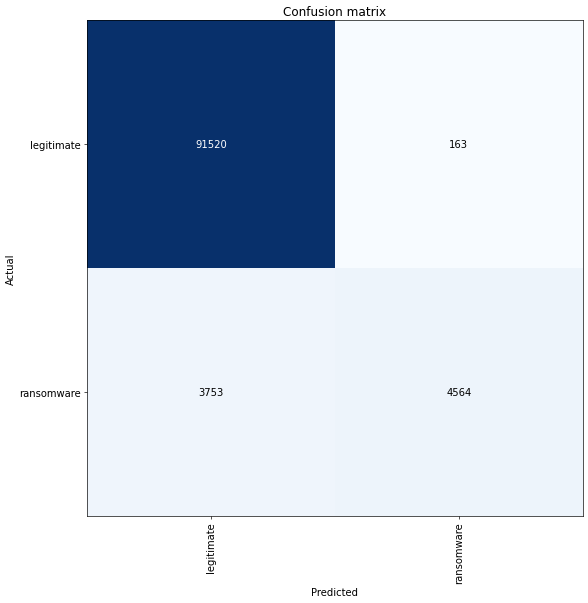

In [27]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)